<a href="https://colab.research.google.com/github/MilindiSenevirathne/COVID-19_Test/blob/main/Outlier_detection_usin_SOM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import geopandas as gpd

In [2]:
data =gpd.read_file('/content/sample_data/COVID-19_Cases_US.csv')
data.head()

,X,Y,OBJECTID,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Recovered,...,Active,Admin2,FIPS,Combined_Key,Incident_Rate,People_Tested,People_Hospitalized,UID,ISO3,geometry
0,-86.64408227,32.53952745,1,Alabama,US,2023/03/10 13:21:02+00,32.53952745,-86.64408227,19790,,...,,Autauga,01001,"Autauga, Alabama, US",35422.148239632,,,84001001,USA,None
1,-87.72207058,30.7277499100001,2,Alabama,US,2023/03/10 13:21:02+00,30.72774991,-87.72207058,69860,,...,,Baldwin,01003,"Baldwin, Alabama, US",31294.5160683408,,,84001003,USA,None
2,-85.3871286,31.8682630000001,3,Alabama,US,2023/03/10 13:21:02+00,31.868263,-85.3871286,7485,,...,,Barbour,01005,"Barbour, Alabama, US",30320.8296200275,,,84001005,USA,None
3,-87.1251146,32.9964206400001,4,Alabama,US,2023/03/10 13:21:02+00,32.99642064,-87.1251146,8091,,...,,Bibb,01007,"Bibb, Alabama, US",36130.2134500313,,,84001007,USA,None
4,-86.5679059299999,33.9821091800001,5,Alabama,US,2023/03/10 13:21:02+00,33.98210918,-86.56790593,18704,,...,,Blount,01009,"Blount, Alabama, US",32345.3117974613,,,84001009,USA,None


In [3]:
data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3272 entries, 0 to 3271
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   X                    3272 non-null   object  
 1   Y                    3272 non-null   object  
 2   OBJECTID             3272 non-null   object  
 3   Province_State       3272 non-null   object  
 4   Country_Region       3272 non-null   object  
 5   Last_Update          3272 non-null   object  
 6   Lat                  3272 non-null   object  
 7   Long_                3272 non-null   object  
 8   Confirmed            3272 non-null   object  
 9   Recovered            3272 non-null   object  
 10  Deaths               3272 non-null   object  
 11  Active               3272 non-null   object  
 12  Admin2               3272 non-null   object  
 13  FIPS                 3272 non-null   object  
 14  Combined_Key         3272 non-null   object  
 15  Incident_Rate

In [4]:
data.geom_type

0       None
1       None
2       None
3       None
4       None
        ... 
3267    None
3268    None
3269    None
3270    None
3271    None
Length: 3272, dtype: object

In [5]:
from shapely.geometry import Point

# Create a geometry column with Point geometries from latitude and longitude columns
def create_point(row):
    try:
        longitude = float(row['Long_'])
        latitude = float(row['Lat'])
        return Point(longitude, latitude)
    except ValueError:
        return None

data['geometry'] = data.apply(create_point, axis=1)

# Remove rows with empty or invalid geometries
data = data.dropna(subset=['geometry'])

# Convert the GeoDataFrame to a polygon dataset
data = data.set_geometry('geometry')

data.geom_type

0       Point
1       Point
2       Point
3       Point
4       Point
        ...  
3266    Point
3267    Point
3268    Point
3270    Point
3271    Point
Length: 3204, dtype: object

In [6]:
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.covariance import MinCovDet

In [8]:
def calculate_robust_distance(data):
    mcd = MinCovDet()
    mcd.fit(data)
    robust_covariance = mcd.covariance_
    robust_distances = np.sqrt(np.sum(np.square(np.dot(data - mcd.location_, np.linalg.inv(robust_covariance))), axis=1))
    return robust_distances

In [12]:
import pandas as pd

dataset = pd.DataFrame({
    'Lat': pd.to_numeric(data['Lat'], errors='coerce'),
    'Long_': pd.to_numeric(data['Long_'], errors='coerce'),
    'Confirmed': pd.to_numeric(data['Confirmed'], errors='coerce')
})

robust_distances = calculate_robust_distance(dataset)
robust_distances

array([0.19446816, 0.70131632, 0.17989736, ..., 0.21954681, 0.16275213,
       0.14451338])

In [22]:
def detect_spatial_outliers(data, threshold):
    robust_distances = calculate_robust_distance(data)
    outliers = np.where(robust_distances > threshold)[0]
    return outliers

In [23]:
kmeans = MiniBatchKMeans(n_clusters=5)
kmeans.fit(dataset)

threshold = 3.0

outliers = detect_spatial_outliers(dataset, threshold)
outliers

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([ 104,  107,  187,  193,  196,  201,  205,  216,  219,  220,  222,
        223,  229,  326,  335,  348,  363,  368,  370,  548,  610, 1225,
       1279, 1292, 1311, 1339, 1583, 1749, 1775, 1830, 1851, 1857, 1858,
       1868, 1879, 1887, 1949, 1981, 2060, 2067, 2245, 2294, 2584, 2615,
       2657, 2701, 2820, 2827, 2858, 3031, 3149])

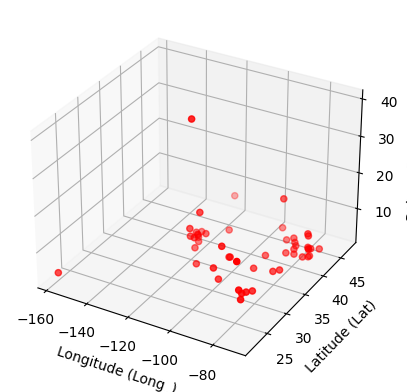

In [36]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Import for 3D plotting

# Define the dataset as you did before
dataset = pd.DataFrame({
    'Lat': pd.to_numeric(data['Lat'], errors='coerce'),
    'Long_': pd.to_numeric(data['Long_'], errors='coerce'),
    'Confirmed': pd.to_numeric(data['Confirmed'], errors='coerce')
})

# Extract Longitude and Latitude values for the outliers
outlier_coords = dataset.iloc[outliers][['Long_', 'Lat']].values

# Create a 3D scatter plot to visualize the outliers
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the outliers with their Longitude and Latitude values
ax.scatter(outlier_coords[:, 0], outlier_coords[:, 1], robust_distances[outliers], c='r', marker='o', label='Outliers')

# Set labels for the axes
ax.set_xlabel('Longitude (Long_)')
ax.set_ylabel('Latitude (Lat)')
ax.set_zlabel('Robust Distances')

# Show the plot
plt.show()